In [1]:
from MieSppForce import  green_func, frenel, dipoles, force
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad

In [2]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

In [7]:
def get_directivity(wl, P,M, eps_Au):
    px,py,pz = P
    mx, my,mz = M
    ka = -1j*np.sqrt(1/(eps_Au(wl)+1))
    kspp = np.sqrt(eps_Au(wl)/(eps_Au(wl)+1))
    I = lambda phi:  np.abs((mx/c_const+1j*ka*py)*np.sin(phi) + (my/c_const - 1j*ka*px)*np.cos(phi) - kspp*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return  lambda phi: 2 * np.pi * I(phi) / Imax
    


In [5]:
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

R = 110
dist = 2
a_angle = np.pi/4
angle = 70*np.pi/180
STOP = 45
point = [0,0,dist+R]
z0 = point[2]
wls=np.linspace(400,1100,100)
phase = 0

k0 = lambda wl: 2*np.pi/wl/1e-9
omega = lambda wl: 2*np.pi*c_const/wl/1e-9

In [8]:
Rs = np.array([105, 125])
wl = 800
STOP = 45
angle = 25*np.pi/180

a_angle = np.pi/4

phase = -np.pi/2

F_x_from_R = np.empty((len(Rs), 8))
F_y_from_R = np.empty_like(F_x_from_R)
F_z_from_R = np.empty_like(F_x_from_R)

P_from_R,M_from_R = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)


for i in tqdm(range(len(Rs))):
    point = [0,0,dist+Rs[i]]
    f =  force.F(wl, eps_Au, point, Rs[i], eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x_from_R[i,:] = f[0]
    F_y_from_R[i,:] = f[1]
    F_z_from_R[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, Rs[i], eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
   
    p,m = p[:,0],m[:,0]
    P_from_R[i,:],M_from_R[i,:]=p,m
    
    

PHI = np.linspace(-np.pi, np.pi, 100)

directivityR = np.empty((len(PHI), len(Rs)))
for R_idx, R_i in enumerate(Rs):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P_from_R[R_idx,:], M_from_R[R_idx,:], eps_Au)
        directivityR[angle_idx, R_idx] = D(PHI[angle_idx])

        

100%|██████████| 2/2 [00:00<00:00, 621.10it/s]


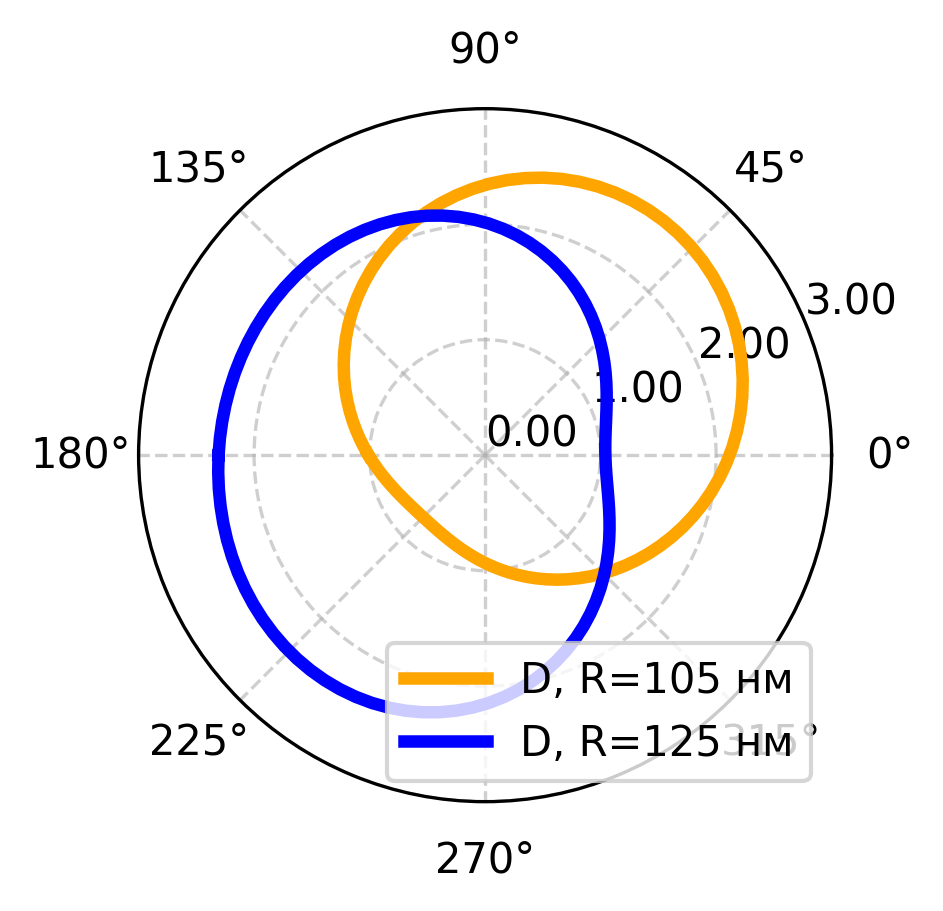

In [31]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'},dpi=300, figsize=(3,3))
ind = 0

ax.plot(PHI, directivityR[:,ind]*1.6, label=f'D, R={Rs[ind]} нм', color='orange', linewidth=3)
ind = 1
ax.plot(PHI, directivityR[:,ind]*1.88, label=f'D, R={Rs[ind]} нм', color='blue', linewidth=3)


ax.set_rticks([0, 1, 2, 3])  
ax.set_yticklabels([f"{0:.2f}", f"{1:.2f}", f"{2:.2f}", f"{3:.2f}"], fontsize=10)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.show()
